In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbn
import pandas as pd
import glob
import os

In [41]:
pwd

'C:\\Users\\User\\anaconda_projects\\db'

In [43]:
cd ../..

C:\Users\User


In [45]:
cd "OneDrive - University of Aberdeen"

C:\Users\User\OneDrive - University of Aberdeen


In [47]:
cd "BT5511 Comp"

C:\Users\User\OneDrive - University of Aberdeen\BT5511 Comp


In [49]:
cd "Report files"

C:\Users\User\OneDrive - University of Aberdeen\BT5511 Comp\Report files


In [51]:

data_dir = "./"  
file_pattern = "*.txt"  

files = glob.glob(os.path.join(data_dir, file_pattern))

df_list = []


for file in files:
    try:
       
        df = pd.read_csv(file, delimiter="\t", encoding="utf-8")  

        df["Source_File"] = os.path.basename(file)

        
        df_list.append(df)

    except Exception as e:
        print(f"Error reading {file}: {e}")


if df_list:
    master_df = pd.concat(df_list, ignore_index=True)

    # Save the aggregated data as a CSV
    master_df.to_csv("aggregated_data.csv", index=False)
    print("Aggregated data saved as 'aggregated_data.csv'.")

else:
    print("No valid files found or processed.")


Aggregated data saved as 'aggregated_data.csv'.


In [53]:
from difflib import SequenceMatcher

def classify_mutation(wt_seq, mut_seq):
    matcher = SequenceMatcher(None, wt_seq, mut_seq)
    diffs = [block for block in matcher.get_opcodes() if block[0] != "equal"]
    
    mutation_types = []
    for tag, i1, i2, j1, j2 in diffs:
        if tag == "replace":
            mutation_types.append(f"Substitution ({wt_seq[i1:i2]} → {mut_seq[j1:j2]})")
        elif tag == "insert":
            mutation_types.append(f"Insertion ({mut_seq[j1:j2]} at position {i1})")
        elif tag == "delete":
            mutation_types.append(f"Deletion ({wt_seq[i1:i2]} at position {i1})")

    return "; ".join(mutation_types) if mutation_types else "No Mutation"

for file in files:
    try:
        df = pd.read_csv(file, delimiter="\t", encoding="utf-8")

        df["Wildtype mRNA"] = df[
            ["mRNA.Expression.WT.Rep1", 
             "mRNA.Expression.WT.Rep2", 
             "mRNA.Expression.WT.Rep3"]
        ].mean(axis=1)

        df["Mutant mRNA"] = df[
            ["mRNA.Expression.Mut.Rep1", 
             "mRNA.Expression.Mut.Rep2", 
             "mRNA.Expression.Mut.Rep3"]
        ].mean(axis=1)

        df["Wildtype protein"] = df[
            ["Protein.Expression.WT.Rep1", 
             "Protein.Expression.WT.Rep2", 
             "Protein.Expression.WT.Rep3"]
        ].mean(axis=1)

        df["Mutant protein"] = df[
            ["Protein.Expression.Mut.Rep1", 
             "Protein.Expression.Mut.Rep2", 
             "Protein.Expression.Mut.Rep3"]
        ].mean(axis=1)

        df["Wildtype viability"] = df[
            ["CellViability.WT.Rep1", 
             "CellViability.WT.Rep2", 
             "CellViability.WT.Rep3"]
        ].mean(axis=1)

        df["Mutant viability"] = df[
            ["CellViability.Mut.Rep1", 
             "CellViability.Mut.Rep2", 
             "CellViability.Mut.Rep3"]
        ].mean(axis=1)

        df["Promoter_WT"] = df["WildType.Sequence"].str[:1000]

        df["Mutation Type"] = df.apply(lambda row: classify_mutation(row["WildType.Sequence"], 
                                                                     row["Mutant.Sequence"]), axis=1)

        df["Cell Viability Change"] = df["Mutant viability"] - df["Wildtype viability"]
        df["mRNA Change"] = df["Mutant mRNA"] - df["Wildtype mRNA"]
        df["Protein Change"] = df["Mutant protein"] - df["Wildtype protein"]

        df["Source_File"] = os.path.basename(file) 
        df_list.append(df)

    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")

if df_list:
    master_df = pd.concat(df_list, ignore_index=True)
    master_df.to_csv("aggregated_data.csv", index=False)
    print("✅ Aggregated data saved as 'aggregated_data.csv'.")

    master_df["Impact Score"] = abs(master_df["Cell Viability Change"]) + \
                                abs(master_df["mRNA Change"]) + abs(master_df["Protein Change"])
    
    top_5_mutations = master_df.nlargest(5, "Impact Score")
    top_5_mutations.to_csv("top_5_mutations.csv", index=False)
    print("🏆 Top 5 mutations saved as 'top_5_mutations.csv'.")

else:
    print("❌ No valid files found or processed.")

✅ Aggregated data saved as 'aggregated_data.csv'.
🏆 Top 5 mutations saved as 'top_5_mutations.csv'.


In [69]:
plot_df = pd.DataFrame(top_5_mutations)
plot_df.head()

,Gene,WildType.Sequence,Mutant.Sequence,mRNA.Expression.WT.Rep1,mRNA.Expression.WT.Rep2,mRNA.Expression.WT.Rep3,mRNA.Expression.Mut.Rep1,mRNA.Expression.Mut.Rep2,mRNA.Expression.Mut.Rep3,Protein.Expression.WT.Rep1,...,Wildtype protein,Mutant protein,Wildtype viability,Mutant viability,Promoter_WT,Mutation Type,Cell Viability Change,mRNA Change,Protein Change,Impact Score
57,Avon4,TGAATCTAAGATTAAGTGGATATCGCCTTGACTTCTTTATCCATCC...,TGAATCTAAGATTAAGTGGATATCGCCTTGACTTCTTTATCCATCC...,1.398400,1.745494,4.394474,2.973012,2.412630,6.489425,29811.000000,...,35318.333333,55350.000000,0.642143,5.857854,TGAATCTAAGATTAAGTGGATATCGCCTTGACTTCTTTATCCATCC...,Substitution (GCCCACGTATTACTATGTGTTGTTGTGTCGGC...,5.215711,1.445566,20031.666667,20038.327943
65,Dsgt9a1,ATAATCGCTGGTGTACTTCAAGTTACGACTTGAGTACGCATATCCA...,ATAATCGCTGGTGTACTTCAAGTTACGACTTGAGTACGCATATCCA...,9.898111,2.371426,101.458408,20.418024,3.124716,101.491889,25570.000000,...,19030.333333,36188.666667,0.304203,0.000000,ATAATCGCTGGTGTACTTCAAGTTACGACTTGAGTACGCATATCCA...,Substitution (CATAGATGGGTTATGCGAACCGCTCCGGATGC...,-0.304203,3.768895,17158.333333,17162.406431
87,Nect1c1,ATACCTCTTTGGCTCCAATCCTAGTAAGGACCGAGTCGTTTATCTT...,ATACCTCTTTGGCTCCAATCCTAGTAAGGACCGAGTCGTTTATCTT...,3.889706,22.464746,2.581448,2.739003,21.566978,2.398317,20618.000000,...,30209.666667,13595.666667,0.300318,4.737217,ATACCTCTTTGGCTCCAATCCTAGTAAGGACCGAGTCGTTTATCTT...,Substitution (TATATAATCTTGGTCTGCGCTCCTTTACTGCA...,4.436899,-0.743867,-16614.000000,16619.180766
89,Oyu3a9,GGTACGAGCTCCGTCCTATGTCGACCGGGAGCTGGAGCCCCAGCTG...,TCACAATTCCGGCGTGACCATAATATCCGGGGTAGAACTCAACATC...,5.294364,40565.218804,919.906250,0.001400,-0.001280,0.000367,2.653321,...,896.525042,0.000142,0.383928,0.000000,GGTACGAGCTCCGTCCTATGTCGACCGGGAGCTGGAGCCCCAGCTG...,Substitution (GGTACGAGCTCCGTCCTATGTCGACCGGGAGC...,-0.383928,-13830.139643,-896.524900,14727.048472
53,Anap7c1,GGGCGCATAGTAGGCAAGACACCTATTGCTAAAAAACGTCCTGGAC...,GGGCGCATAGTAGGCAAGACACCTATTGCTAAAAAACGTCCTGGAC...,1.629126,20.977798,7.266207,-3.674294,-109.439914,-5.597223,25803.000000,...,21147.666667,10071.333333,0.522474,0.000000,GGGCGCATAGTAGGCAAGACACCTATTGCTAAAAAACGTCCTGGAC...,Substitution (TATATATAGCGTTTCAAAATGTCGAAAGTGCA...,-0.522474,-49.528187,-11076.333333,11126.383994


In [59]:
columns_to_remove = ["mRNA.Expression.WT.Rep1", "mRNA.Expression.WT.Rep2", "mRNA.Expression.WT.Rep3", "mRNA.Expression.Mut.Rep1", "mRNA.Expression.Mut.Rep2", "mRNA.Expression.Mut.Rep3", "Protein.Expression.WT.Rep1", "Protein.Expression.WT.Rep2", "Protein.Expression.WT.Rep3", "Protein.Expression.Mut.Rep1", "Protein.Expression.Mut.Rep2", "Protein.Expression.Mut.Rep3", "CellViability.WT.Rep1", "CellViability.WT.Rep2", "CellViability.WT.Rep3", "CellViability.Mut.Rep1", "CellViability.Mut.Rep2", "CellViability.Mut.Rep3", "Promoter_WT", "Mutation Type", "WildType.Sequence", "Mutant.Sequence"]  
new_table = plot_df.drop(columns=columns_to_remove)
new_table.head()

,Gene,Source_File,Wildtype mRNA,Mutant mRNA,Wildtype protein,Mutant protein,Wildtype viability,Mutant viability,Cell Viability Change,mRNA Change,Protein Change,Impact Score
57,Avon4,Avon4_data_file.txt,2.512790,3.958356,35318.333333,55350.000000,0.642143,5.857854,5.215711,1.445566,20031.666667,20038.327943
65,Dsgt9a1,Dsgt9a1_data_file.txt,37.909315,41.678210,19030.333333,36188.666667,0.304203,0.000000,-0.304203,3.768895,17158.333333,17162.406431
87,Nect1c1,Nect1c1_data_file.txt,9.645300,8.901433,30209.666667,13595.666667,0.300318,4.737217,4.436899,-0.743867,-16614.000000,16619.180766
89,Oyu3a9,Oyu3a9_data_file.txt,13830.139806,0.000162,896.525042,0.000142,0.383928,0.000000,-0.383928,-13830.139643,-896.524900,14727.048472
53,Anap7c1,Anap7c1_data_file(1).txt,9.957710,-39.570477,21147.666667,10071.333333,0.522474,0.000000,-0.522474,-49.528187,-11076.333333,11126.383994


In [61]:
columns_to_remove = ["Source_File"]
table2 = new_table.drop(columns=columns_to_remove)
table2.head()

,Gene,Wildtype mRNA,Mutant mRNA,Wildtype protein,Mutant protein,Wildtype viability,Mutant viability,Cell Viability Change,mRNA Change,Protein Change,Impact Score
57,Avon4,2.512790,3.958356,35318.333333,55350.000000,0.642143,5.857854,5.215711,1.445566,20031.666667,20038.327943
65,Dsgt9a1,37.909315,41.678210,19030.333333,36188.666667,0.304203,0.000000,-0.304203,3.768895,17158.333333,17162.406431
87,Nect1c1,9.645300,8.901433,30209.666667,13595.666667,0.300318,4.737217,4.436899,-0.743867,-16614.000000,16619.180766
89,Oyu3a9,13830.139806,0.000162,896.525042,0.000142,0.383928,0.000000,-0.383928,-13830.139643,-896.524900,14727.048472
53,Anap7c1,9.957710,-39.570477,21147.666667,10071.333333,0.522474,0.000000,-0.522474,-49.528187,-11076.333333,11126.383994


In [63]:
columns_to_remove = ["Wildtype mRNA", "Mutant mRNA", "Wildtype protein", "Mutant protein"]
maintable2 = table2.drop(columns=columns_to_remove)
maintable2.head()

,Gene,Wildtype viability,Mutant viability,Cell Viability Change,mRNA Change,Protein Change,Impact Score
57,Avon4,0.642143,5.857854,5.215711,1.445566,20031.666667,20038.327943
65,Dsgt9a1,0.304203,0.000000,-0.304203,3.768895,17158.333333,17162.406431
87,Nect1c1,0.300318,4.737217,4.436899,-0.743867,-16614.000000,16619.180766
89,Oyu3a9,0.383928,0.000000,-0.383928,-13830.139643,-896.524900,14727.048472
53,Anap7c1,0.522474,0.000000,-0.522474,-49.528187,-11076.333333,11126.383994


In [65]:
columns_to_remove = ["Wildtype viability", "Mutant viability", "mRNA Change", "Cell Viability Change", "Protein Change"]
maintable = table2.drop(columns=columns_to_remove)
maintable.head()

,Gene,Wildtype mRNA,Mutant mRNA,Wildtype protein,Mutant protein,Impact Score
57,Avon4,2.512790,3.958356,35318.333333,55350.000000,20038.327943
65,Dsgt9a1,37.909315,41.678210,19030.333333,36188.666667,17162.406431
87,Nect1c1,9.645300,8.901433,30209.666667,13595.666667,16619.180766
89,Oyu3a9,13830.139806,0.000162,896.525042,0.000142,14727.048472
53,Anap7c1,9.957710,-39.570477,21147.666667,10071.333333,11126.383994


<Axes: xlabel='Gene', ylabel='Impact Score'>

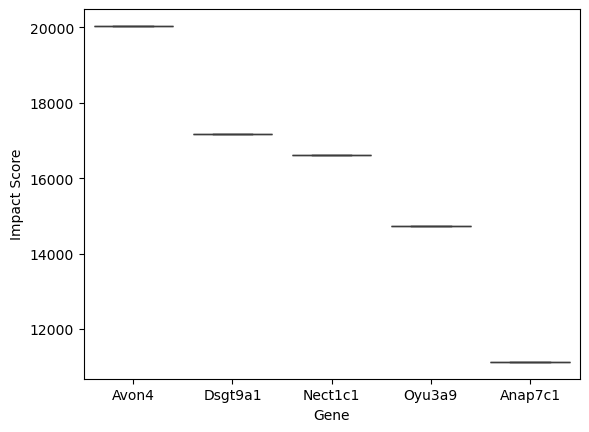

In [67]:
sbn.boxplot(plot_df, x="Gene", y="Impact Score", hue="Gene")

In [22]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [109]:
print(plot_df["mRNA Change"].describe())
print(plot_df["mRNA Change"].unique())

count        5.000000
mean     -2775.039448
std       6180.028575
min     -13830.139643
25%        -49.528187
50%         -0.743867
75%          1.445566
max          3.768895
Name: mRNA Change, dtype: float64
[ 1.44556584e+00  3.76889462e+00 -7.43867346e-01 -1.38301396e+04
 -4.95281873e+01]


C:\Users\User\AppData\Local\Temp\ipykernel_28016\3947340134.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend(fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_28016\3947340134.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0, w_pad=4.0, h_pad=4.0)


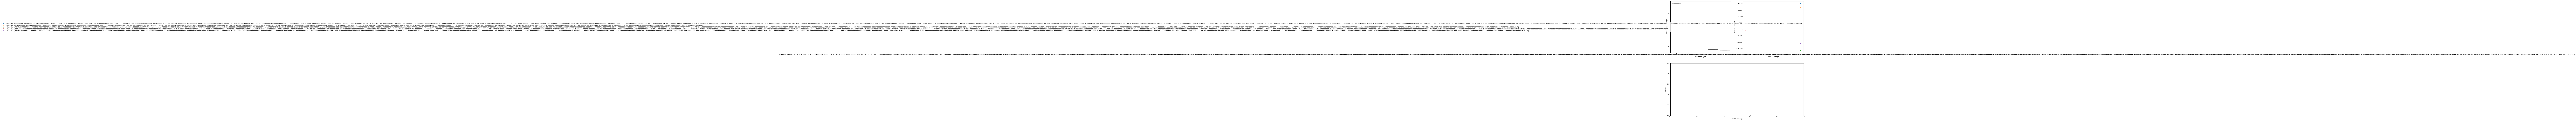

In [132]:
fig, ax = plt.subplot_mosaic([["box", "scatter"],["hist", "hist"]], 
                           figsize=(14, 12),  
                           layout="tight")


sbn.boxplot(plot_df, x="Mutation Type", y="Cell Viability Change", hue="Mutation Type", ax=ax["box"])
sbn.scatterplot(plot_df, x="mRNA Change", y="Protein Change", hue="Mutation Type", ax=ax["scatter"])
sbn.kdeplot(plot_df, x="mRNA Change", hue="Gene", ax=ax["hist"], warn_singular=False)


for axis in ax.values():
    axis.set_xlabel(axis.get_xlabel(), fontsize=9)
    axis.set_ylabel(axis.get_ylabel(), fontsize=9)
    axis.tick_params(labelsize=8) 
    if axis.get_legend() is not None:
        axis.legend(fontsize=8)


plt.tight_layout(pad=2.0, w_pad=4.0, h_pad=4.0)
plt.show()

In [134]:
fig, ax = plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

sbn.boxplot(plot_df, x="Mutation Type", y="Cell Viability Change", hue="Mutation Type", ax=ax["box"])
sbn.scatterplot(plot_df, x="mRNA Change", y="Protein Change", hue="Mutation Type", ax=ax["scatter"])
sbn.kdeplot(plot_df, x="mRNA Change", hue="Gene", ax=ax["hist"], warn_singular=False)

plt.show()

TypeError: cannot unpack non-iterable NoneType object

<Figure size 640x480 with 0 Axes>

In [136]:
pwd

'C:\\Users\\User\\OneDrive - University of Aberdeen\\BT5511 Comp\\Report files'